In [2]:
import os
import pandas as pd
import janitor
import numpy as np
import forestplot as fp
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams['font.monospace'] = ['Noto Mono', 'Tlwg Mono', 'Courier New']
from typing import Iterable, Optional

# ============================================================================
fp_loq_lod_values = "./data/edc-lod-loq.csv"
fp_cordblood_tf_estimates = "./data/pfas-tf-model5-cordblood.dta"
fp_cordblood_completeness = "./data/edc-gusto-completeness-tabulation.csv"

os.path.exists(fp_loq_lod_values)
os.path.exists(fp_cordblood_tf_estimates)
os.path.exists(fp_cordblood_completeness)

pfas_list = ["pfbs", "pfna", "pfoa", "pfos", "pfhxs", "pfba", "pfda", "pfunda"]

In [3]:
try:
    df_cb = (
        pd.read_stata(fp_cordblood_tf_estimates)
        # ========================================================================
        # Convert the specs into a single column for the pfas name
        .fillna(0)
        .assign(pfas=lambda df_: pd.from_dummies(df_[pfas_list]))
        .remove_columns(pfas_list)
        # ========================================================================
        # Get LOD/LOQ values
        .merge(
            (
                pd.read_csv(fp_loq_lod_values).assign(
                    # LOD/LOQ have been divided by sqrt(2) for imputation
                    # Multiply by sqrt(2) to convert back to original
                    lod=lambda df_: df_["lod"] * np.sqrt(2),
                    loq=lambda df_: df_["loq"] * np.sqrt(2),
                    pfas=lambda df_: df_["chemical_name"].str.lower(),
                )
            ),
            how="left",
            on="pfas",
            validate="1:1",
        )
        # ========================================================================
        # Get completeness
        .merge(
            (pd.read_csv(fp_cordblood_completeness)),
            how="left",
            on="chemical_name",
            validate="1:1",
        )
        # ========================================================================
        # Format cell values for alignment
        # Pad the measured column
        .assign(measured=lambda df_: df_["measured"].apply(str).str.pad(len("   n")))
        # Pad the measured, < LOD, < LOQ columns
        # So that they are padded to the left
        .assign(
            **{
                k: lambda df_, col=k: df_[col]
                .apply(str)
                .str.pad(len(" < loq"), side="left")
                for k in ["LOD", "LOQ"]
            }
        )
        # Round the LOD/LOQ values and turn into string
        .assign(
            **{
                k: lambda df_, col=k: df_[col].apply(lambda x: "{:.{}f}".format(x, 3))
                for k in ["lod", "loq"]
            }
        )
        .assign(**{k: lambda df_, col=k: df_[col] + " ng/mL" for k in ["lod", "loq"]})
        .sort_values(
            ["measured", "loq", "lod"],
            ascending=[False, False, False],
            ignore_index=True,
        )
    )
    df_cb.to_csv(
        "./data/coefplot-pfas-transport-facilities-model5-cordblood.csv", index=False
    )
except:
    df_cb = (
        pd.read_csv("./data/coefplot-pfas-transport-facilities-model5-cordblood.csv")
        # ========================================================================
        # Format cell values for alignment
        # Pad the measured column
        .assign(measured=lambda df_: df_["measured"].apply(str).str.pad(len("   n")))
        # Pad the measured, < LOD, < LOQ columns
        # So that they are padded to the left
        .assign(
            **{
                k: lambda df_, col=k: df_[col]
                .apply(str)
                .str.pad(len(" < loq"), side="left")
                for k in ["LOD", "LOQ"]
            }
        ).sort_values(
            ["measured", "loq", "lod"],
            ascending=[False, False, False],
            ignore_index=True,
        )
    )

df_cb

,spec_id,beta,se,u95,l95,u90,l90,tstat,pval,pfas,lod,loq,chemical_name,measured,LOD,LOQ,not_measured
0,1,0.109248,0.039837,0.190851,0.027645,0.177016,0.041480,2.742365,0.010513,pfbs,0.078 ng/mL,5.000 ng/mL,PFBS,784,0,0,0
1,2,0.107639,0.039465,0.188480,0.026798,0.174775,0.040503,2.727424,0.010894,pfna,0.016 ng/mL,0.100 ng/mL,PFNA,784,0,0,0
2,3,0.063016,0.085015,0.237162,-0.111130,0.207638,-0.081607,0.741228,0.464727,pfoa,0.009 ng/mL,0.100 ng/mL,PFOA,784,0,0,0
3,4,0.096990,0.058849,0.217537,-0.023556,0.197100,-0.003119,1.648125,0.110505,pfos,0.027 ng/mL,0.100 ng/mL,PFOS,783,0,1,1
4,5,0.032664,0.027232,0.088446,-0.023118,0.078989,-0.013661,1.199465,0.240399,pfhxs,0.024 ng/mL,0.100 ng/mL,PFHxS,777,1,6,7
5,6,0.163727,0.045036,0.255980,0.071474,0.240339,0.087114,3.635432,0.001106,pfba,0.410 ng/mL,0.500 ng/mL,PFBA,773,11,0,11
6,7,0.018851,0.024424,0.068881,-0.031179,0.060399,-0.022697,0.771836,0.446677,pfunda,0.011 ng/mL,0.100 ng/mL,PFUnDA,754,2,28,30
7,8,0.061571,0.056721,0.177759,-0.054616,0.158061,-0.034918,1.085517,0.286950,pfda,0.010 ng/mL,0.100 ng/mL,PFDA,750,0,34,34


In [4]:
def save_mpl_fig(
    savepath: str, formats: Optional[Iterable[str]] = None, dpi: Optional[int] = None
) -> None:
    """Save matplotlib figures to ../output.

    Will handle saving in png and in pdf automatically using the same file stem.

    Parameters
    ----------
    savepath: str
        Name of file to save to. No extensions.
    formats: Array-like
        List containing formats to save in. (By default 'png' and 'pdf' are saved).
        Do a:
            plt.gcf().canvas.get_supported_filetypes()
        or:
            plt.gcf().canvas.get_supported_filetypes_grouped()
        To see the Matplotlib-supported file formats to save in.
        (Source: https://stackoverflow.com/a/15007393)
    dpi: int
        DPI for saving in png.

    Returns
    -------
    None
    """
    # Save pdf
    plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)

    # save png
    plt.savefig(f"{savepath}.png", dpi=dpi, bbox_inches="tight", pad_inches=0)

    # Save additional file formats, if specified
    if formats:
        for format in formats:
            plt.savefig(
                f"{savepath}.{format}",
                dpi=None,
                bbox_inches="tight",
                pad_inches=0,
            )
    return None

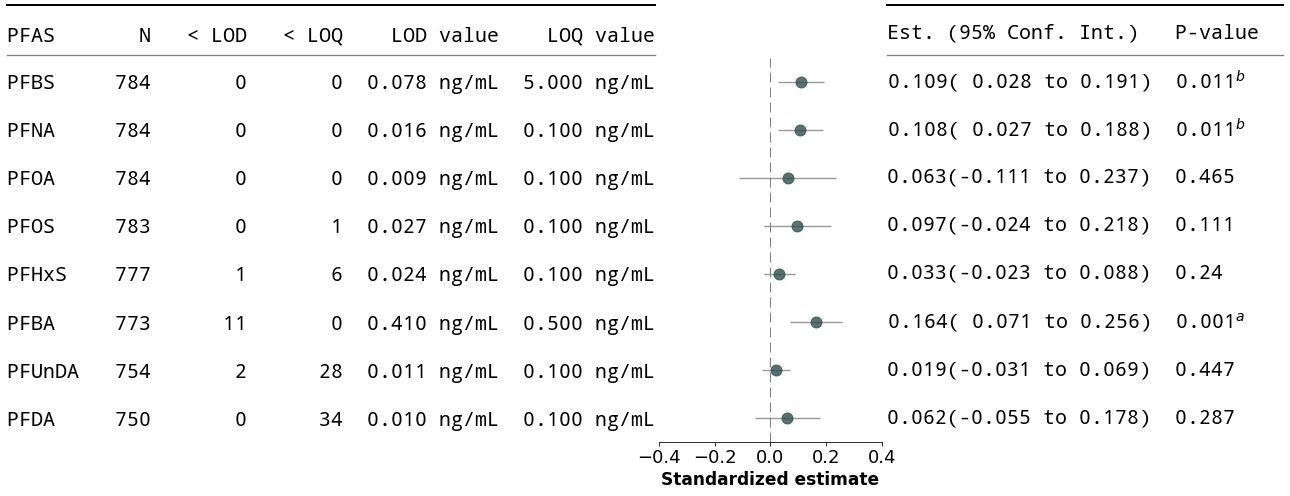

In [5]:
selected_pfas_opts = dict(
    estimate="beta",
    ll="l95",
    hl="u95",
    varlabel="chemical_name",
    pval="pval",
    annote=["measured", "LOD", "LOQ", "lod", "loq"],
    annoteheaders=["   N", " < LOD", " < LOQ", "  LOD value", "  LOQ value"],
    rightannote=["est_ci", "formatted_pval"],
    right_annoteheaders=["Est. (95% Conf. Int.)", "P-value"],
    table=True,
    variable_header="PFAS",
    decimal_precision=3,
    xlabel="Standardized estimate",
    xlabel_size=17,
    xticks=[-0.4, -0.2, 0, 0.2, 0.4],
    symbols=["$^a$", "$^b$", "$^c$"],
    **{
        "marker": "o",  # set maker symbol as diamond
        "markersize": 120,  # adjust marker size
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
        "xlinecolor": "#808080",  # gray color for x-reference line
        "xtick_size": 18,  # adjust x-ticker fontsize
        "fontsize": 20,
    },
)

fp.forestplot(
    df_cb.query("pfas in @pfas_list"),
    **selected_pfas_opts,
)
save_mpl_fig("./figures/coefplot-8pfas-transport-facilities-model5-cordblood")